In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

%matplotlib inline

In [2]:
import functools
    
def gen_data(dimensions, size, maxval, err_sigma):
    true_b = sps.norm.rvs(size=dimensions + 1)
    X = sps.uniform(-maxval, maxval * 2).rvs(size=(size, dimensions))
    y = X @ true_b[1:] + true_b[0] + sps.norm(scale=err_sigma).rvs(size)
    return true_b, X, y


In [3]:
EPS = 1e-7

def gradient_descent(x, steps, gradient, rate_function):
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    for i in range(steps):
        grad = gradient(x)
        x = x - rate_function(x=x, direction=grad, iteration=i) * grad
        x_values[i + 1] = x
    return x_values

def delayed_gradient_descent(x, steps, gradient, rate_function):
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    previous_grad = np.zeros(shape=(x.size))
    for i in range(steps):
        grad = gradient(x)
        x = x - rate_function(x=x, direction=previous_grad, iteration=i) * previous_grad
        previous_grad = grad
        x_values[i + 1] = x
    return x_values

In [4]:
def AC_SA(x, steps, gradient, L, alpha, prox_map):
    def beta(t):
        return (t + 1) / 2
    
    def gamma(t):
        return (t + 1) / 2 * (alpha / (2 * L))
    
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    x_ag = np.array(x)
    for i in range(steps):
        b = 1 / beta(i + 1)
        
        x_mid = x * b + (1 - b) * x_ag
        grad = gradient(x_mid) * gamma(i + 1)
        
        x = prox_map(x, grad)
        
        x_ag = b * x + (1 - b) * x_ag
        x_values[i + 1] = x
    return x_values

def AC_SA_delayed(x, steps, gradient, L, alpha, prox_map):
    def beta(t):
        return (t + 1) / 2
    
    def gamma(t):
        return (t + 1) / 2 * (alpha / (2 * L))
    
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    x_ag = np.array(x)
    previous_grad = np.zeros(shape=(x.size))
    for i in range(steps):
        b = 1 / beta(i + 1)
        
        x_mid = x * b + (1 - b) * x_ag
        grad = previous_grad * gamma(i + 1)
        previous_grad = gradient(x_mid)
        
        x = prox_map(x, grad)
        
        x_ag = b * x + (1 - b) * x_ag
        x_values[i + 1] = x
    return x_values

def AC_SA_double_delayed(x, steps, gradient, L, alpha, prox_map):
    def beta(t):
        return (t + 1) / 2
    
    def gamma(t):
        return (t + 1) / 2 * (alpha / (2 * L))
    
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    x_ag = np.array(x)
    previous_grad = np.zeros(shape=(x.size))
    previous_grad1 = np.zeros(shape=(x.size))
    for i in range(steps):
        b = 1 / beta(i + 1)
        
        x_mid = x * b + (1 - b) * x_ag
        grad = (previous_grad + previous_grad1) / 2
        grad = grad * gamma(i + 1)
        previous_grad1 = previous_grad
        previous_grad = gradient(x_mid)
        
        x = prox_map(x, grad)
        
        x_ag = b * x + (1 - b) * x_ag
        x_values[i + 1] = x
    return x_values

In [5]:
def newton_descent(x, steps, gradient, hessian):
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    for i in range(steps):
        grad = gradient(x)
        H = hessian(x)
        x = x - np.linalg.pinv(H) @ grad
        x_values[i + 1] = x
    return x_values

def delayed_newton_descent(x, steps, gradient, hessian):
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    previous_grad = np.zeros(shape=(x.size))
    previous_H = np.eye(x.size)
    for i in range(steps):
        grad = gradient(x)
        H = hessian(x)
        x = x - np.linalg.pinv(previous_H) @ previous_grad
        previous_grad = grad
        previous_H = H
        x_values[i + 1] = x
    return x_values

In [6]:
def best_rate_func(function):
    def rate_func(x, direction, **kwargs):
        h = 1
        old_y = function(x)
#         if old_y > function(x - direction):
#             h = -1
        y = function(x - h * direction)
        while old_y > y:
            old_y = y
            h *= 2
            y = function(x - h * direction)
        left = 0
        right = 1
        while left + EPS < right:
            m1 = (left * 2 + right) / 3
            m2 = (left + right * 2) / 3
            if function(x - m1 * h * direction) < function(x - m2 * h * direction):
                right = m2
            else:
                left = m1
        return left * h
    return rate_func

def decaying_rate(koef):
    def rate(iteration, **kwargs):
        return koef / np.sqrt(iteration + 1)
    return rate

def lipschitz_rate(L, koef):
    def rate(**kwargs):
        return L * koef
    return rate

In [7]:
class OLS:
    def __init__(self, X, y):
        Xt = np.insert(X.T, 0, np.ones(X.shape[0])).reshape(-1, X.shape[0])
        self.X = Xt.T
        self.y = y
        
    def gradient(self, b):
        dy = self.X @ b - self.y
        grad = 2 * dy @ self.X
        return grad
    
    def function(self, b):
        dy = self.X @ b - self.y
        return (dy ** 2).sum()
    
    def function_multi(self, B):
        return np.apply_along_axis(self.function, 1, B)
    
    def lipschitz(self):
        return np.abs(self.X.T @ self.X).max()
    
    def experimental_min(self):
        result = gradient_descent(
            np.ones(self.X.shape[1]),
            100000,
            self.gradient,
            lipschitz_rate(1 / self.lipschitz(), 1e-1)
        )
        #result = gradient_descent(np.ones(self.X.shape[1]), 10000, self.gradient, best_rate_func(self.function))
        return self.function(result[-1])
    
    def prox_map(self, x, y):
        return x - y
    
    def hessian(self, b):
        return 2 * self.X.T @ self.X

In [8]:
dims = 3
size = 100
true_b, X, y = gen_data(dims, size, 2, 0.1)
print(true_b)
print(y)

[ 1.4463191  -0.00213686  0.31527136 -0.22932356]
[2.27342522 1.81765234 2.19331597 1.57259521 1.17404483 1.49224473
 1.22554927 1.0148785  1.10749535 0.65694777 1.73216095 1.55752814
 1.78996153 1.95720707 1.88044162 1.56431646 1.66645198 1.87695238
 1.33236548 1.71415852 1.16695278 0.56445963 1.57605542 0.66313515
 0.62878168 1.08663476 1.78900362 1.98188107 0.91650077 1.20380709
 0.77344939 1.58748643 1.51981137 1.22477407 1.50008205 1.64818542
 1.05491027 1.46721238 2.09607129 1.89174532 1.22181341 2.56595145
 1.11029953 1.80341545 0.4082511  1.63159766 1.78124945 1.34472512
 1.60559133 2.02833215 1.8925494  1.2805131  0.98582601 1.27604618
 1.55942264 1.45696724 0.97864198 1.08560518 1.76520768 1.74095158
 1.78072984 1.3731911  0.64001981 1.57909576 1.05523061 1.65133067
 1.51471642 1.37841417 1.04610808 0.99402691 1.1983528  1.95637131
 1.97696709 1.29535121 1.81431679 1.9410896  1.0185124  1.11361684
 0.84548898 1.31537882 1.07660934 0.74799381 1.57374673 1.58091791
 2.461241   

In [9]:
ols = OLS(X, y)
rate = 1 / ols.lipschitz()
print(1/rate)

steps = 100

124.63469636605348


In [10]:
total_min = ols.experimental_min()
total_min

0.9175473522322785

In [11]:
lipschitz_results = gradient_descent(np.ones(dims + 1), steps, ols.gradient, lipschitz_rate(rate, 1e-1))
print(lipschitz_results[-1])
best_results = gradient_descent(np.ones(dims + 1), steps, ols.gradient, best_rate_func(ols.function))
print(best_results[-1])
decay_results = gradient_descent(np.ones(dims + 1), steps, ols.gradient, decaying_rate(1e-3))
print(decay_results[-1])
print(ols.function(lipschitz_results[-1]))

[ 1.44508131 -0.00730081  0.32181216 -0.24453429]
[ 1.4450814  -0.00730076  0.32181214 -0.24453431]
[ 1.43465959 -0.00589296  0.3225571  -0.23294234]
0.9175473522332537


In [12]:
delayed_lipschitz_results = delayed_gradient_descent(np.ones(dims + 1), steps, ols.gradient, lipschitz_rate(rate, 1e-1))
print(lipschitz_results[-1])
delayed_best_results = delayed_gradient_descent(np.ones(dims + 1), steps, ols.gradient, best_rate_func(ols.function))
print(best_results[-1])
delayed_decay_results = delayed_gradient_descent(np.ones(dims + 1), steps, ols.gradient, decaying_rate(1e-3))
print(decay_results[-1])

[ 1.44508131 -0.00730081  0.32181216 -0.24453429]
[ 1.4450814  -0.00730076  0.32181214 -0.24453431]
[ 1.43465959 -0.00589296  0.3225571  -0.23294234]


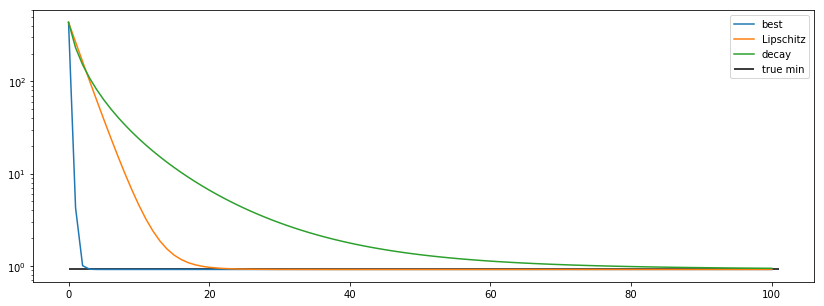

In [13]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(ols.function_multi(best_results), label="best")
plt.plot(ols.function_multi(lipschitz_results), label="Lipschitz")
plt.plot(ols.function_multi(decay_results), label="decay")
plt.hlines([total_min], xmin=0, xmax=best_results.shape[0], label="true min")
plt.legend()
plt.show()

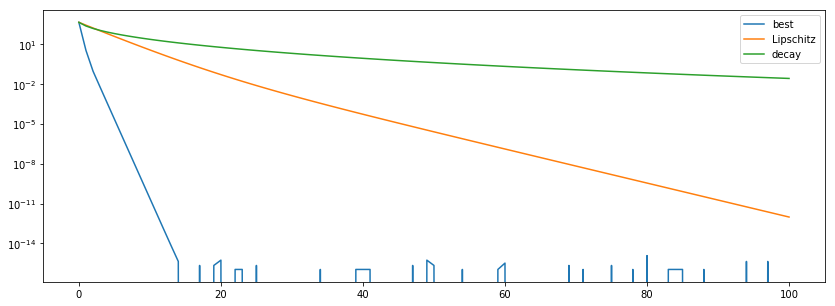

In [14]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(ols.function_multi(best_results) - total_min, label="best")
plt.plot(ols.function_multi(lipschitz_results) - total_min, label="Lipschitz")
plt.plot(ols.function_multi(decay_results) - total_min, label="decay")
plt.legend()
plt.show()

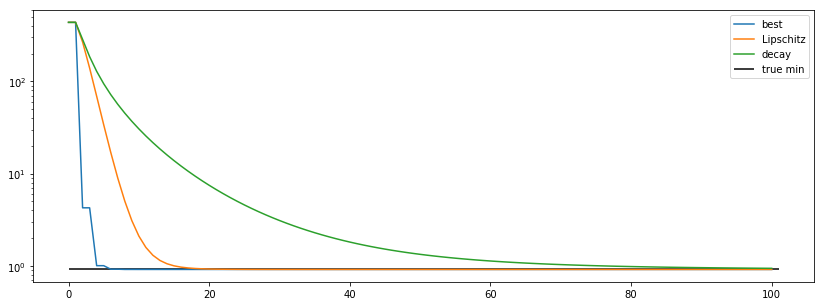

In [15]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(ols.function_multi(delayed_best_results), label="best")
plt.plot(ols.function_multi(delayed_lipschitz_results), label="Lipschitz")
plt.plot(ols.function_multi(delayed_decay_results), label="decay")
plt.hlines([total_min], xmin=0, xmax=best_results.shape[0], label="true min")
plt.legend()
plt.show()

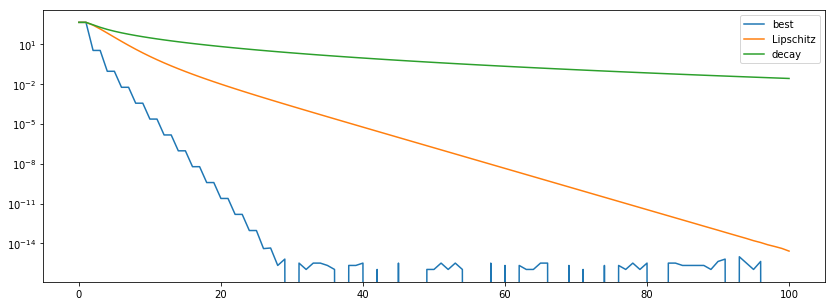

In [16]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(ols.function_multi(delayed_best_results) - total_min, label="best")
plt.plot(ols.function_multi(delayed_lipschitz_results) - total_min, label="Lipschitz")
plt.plot(ols.function_multi(delayed_decay_results) - total_min, label="decay")
plt.legend()
plt.show()

In [17]:
ac_sa_results = AC_SA(np.zeros(dims + 1), steps, ols.gradient, 1/rate, 1, ols.prox_map)
print(ac_sa_results[-1])
delayed_ac_sa_results = AC_SA_delayed(np.zeros(dims + 1), steps, ols.gradient, 1/rate, 1/10, ols.prox_map)
print(delayed_ac_sa_results[-1])
double_delayed_ac_sa_results = AC_SA_double_delayed(np.zeros(dims + 1), steps, ols.gradient, 1/rate, 0.03, ols.prox_map)
print(double_delayed_ac_sa_results[-1])

[ 1.4450814  -0.00730075  0.32181214 -0.24453431]
[ 1.52057309  0.07314922  0.25345019 -0.09423304]
[ 1.43941278  0.01949022  0.46331015 -0.4480651 ]


In [18]:
newton_result = newton_descent(np.ones(dims + 1), steps, ols.gradient, ols.hessian)
print(newton_result[-1])
delayed_newton_result = delayed_newton_descent(np.ones(dims + 1), steps, ols.gradient, ols.hessian)
print(delayed_newton_result[-1])

[ 1.4450814  -0.00730075  0.32181214 -0.24453431]
[ 1.89016279 -1.01460151 -0.35637573 -1.48906862]


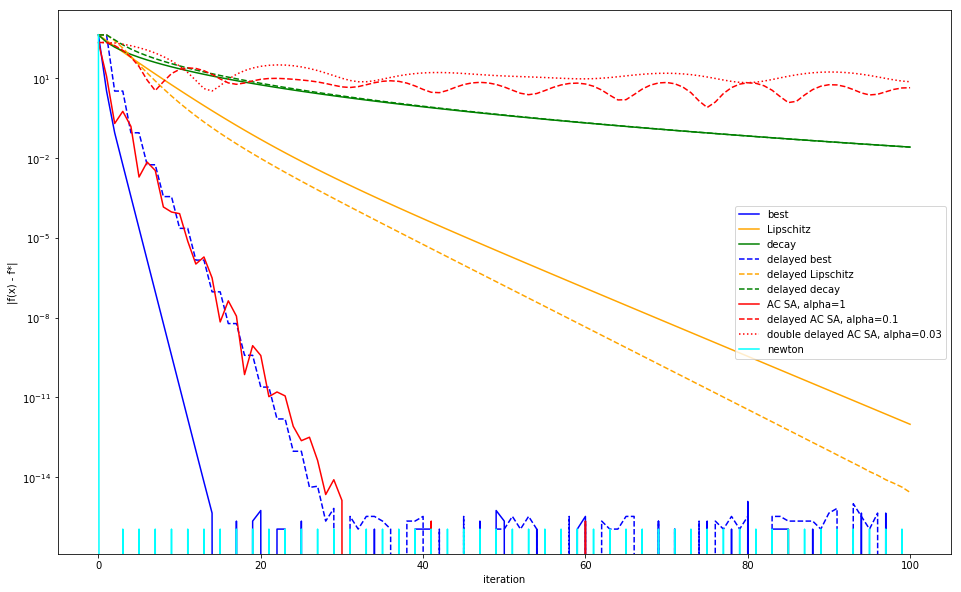

In [23]:
plt.figure(figsize=(16, 10))
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("|f(x) - f*|")

plt.plot(ols.function_multi(best_results) - total_min, label="best", color='blue')
plt.plot(ols.function_multi(lipschitz_results) - total_min, label="Lipschitz", color='orange')
plt.plot(ols.function_multi(decay_results) - total_min, label="decay", color='green')

plt.plot(ols.function_multi(delayed_best_results) - total_min, label="delayed best", color='blue', linestyle="--")
plt.plot(ols.function_multi(delayed_lipschitz_results) - total_min, label="delayed Lipschitz", color='orange', linestyle="--")
plt.plot(ols.function_multi(delayed_decay_results) - total_min, label="delayed decay", color='green', linestyle="--")

plt.plot(ols.function_multi(ac_sa_results) - total_min, label='AC SA, alpha=1', color='red')
plt.plot(ols.function_multi(delayed_ac_sa_results) - total_min, label='delayed AC SA, alpha=0.1', color='red', linestyle = '--')
plt.plot(ols.function_multi(double_delayed_ac_sa_results) - total_min, label='double delayed AC SA, alpha=0.03', color='red', linestyle = ':')

plt.plot(ols.function_multi(newton_result) - total_min, label="newton", color='cyan')
#plt.plot(ols.function_multi(delayed_newton_result) - total_min, label="delayed newton", color='cyan', linestyle="--")

plt.legend()
plt.show()

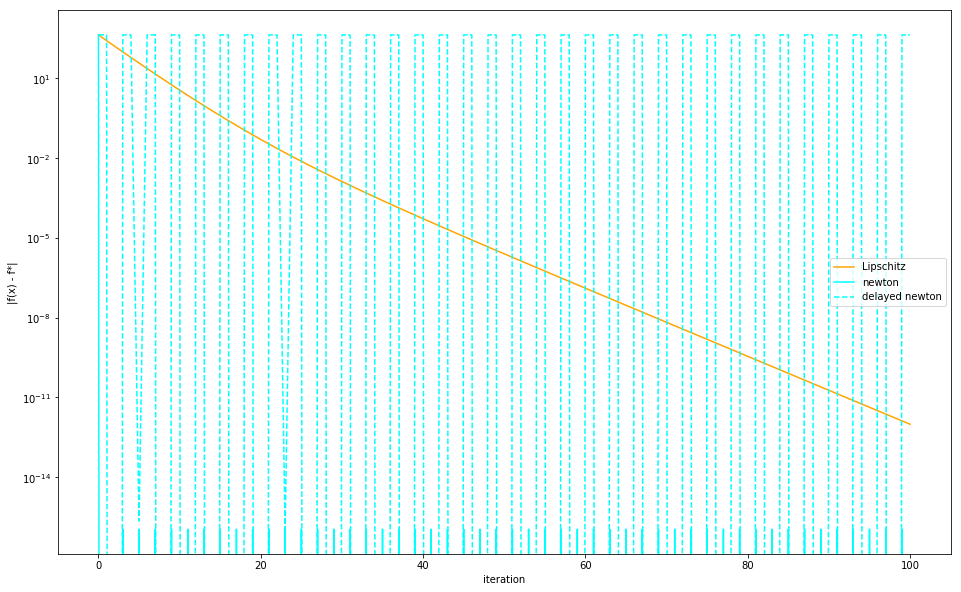

In [24]:
plt.figure(figsize=(16, 10))
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("|f(x) - f*|")

plt.plot(ols.function_multi(lipschitz_results) - total_min, label="Lipschitz", color='orange')
plt.plot(ols.function_multi(newton_result) - total_min, label="newton", color='cyan')
plt.plot(ols.function_multi(delayed_newton_result) - total_min, label="delayed newton", color='cyan', linestyle="--")

plt.legend()
plt.show()

Для logloss, $y_i \in \{-1, 1\}$:
$$
Q(w) = \sum\limits_{i=1}^{n} \ln(1 + \exp (-y_i \langle x_i, w \rangle))
$$
$$
\frac{d}{dw_j} Q(w) = \sum\limits_{i=1}^{n} x_i^j \frac{-y_i \exp (-y_i \langle x_i, w \rangle)}{1 + \exp (-y_i \langle x_i, w \rangle)}
$$
$$
\frac{d^2}{dw_jdw_k} Q(w) = \sum\limits_{i=1}^{n} x_i^j x_i^k \frac{(y_i)^2 \exp (-y_i \langle x_i, w \rangle)}{(1 + \exp (-y_i \langle x_i, w \rangle))^2} = \sum\limits_{i=1}^{n} x_i^j x_i^k \frac{\exp (-y_i \langle x_i, w \rangle)}{(1 + \exp (-y_i \langle x_i, w \rangle))^2}
$$

In [25]:
class LogReg:
    def __init__(self, X, y):
        Xt = np.insert(X.T, 0, np.ones(X.shape[0])).reshape(-1, X.shape[0])
        self.X = Xt.T
        self.y = y

    def gradient(self, b):
        exp = np.exp((self.X @ b) * self.y)
        
        koef =  1 / (1 + exp)
        #koef[np.isnan(koef)] = 1
        
        value = -self.y * koef
        grad = value @ self.X
        return grad

    def function(self, b):
        error = -(self.X @ b) * self.y
        exp = np.exp(error)
        result = np.log(1 + exp)
        mask = np.isposinf(result)
        result[mask] = error[mask]
        return result.sum()
    
    def function_multi(self, B):
        return np.apply_along_axis(self.function, 1, B)
    
    def lipschitz(self):
        return 1000
    
    def experimental_min(self):
        result = gradient_descent(
            np.ones(self.X.shape[1]),
            10000,
            self.gradient,
            lipschitz_rate(1 / self.lipschitz(), 1e-1)
        )
        result = newton_descent(result[-1], 1000, self.gradient, self.hessian)
        #result = gradient_descent(np.ones(self.X.shape[1]), 10000, self.gradient, best_rate_func(self.function))
        return self.function(result[-1])
    
    def prox_map(sefl, x, y):
        return x - y
    
    def hessian(self, b):
        exp = np.exp((self.X @ b) * self.y)
        
        koef =  exp / (1 + exp) ** 2
        koef[np.isnan(koef)] = 0
        H = self.X.T * koef @ self.X
        return H

In [26]:
dims = 3
size = 100
true_b, X, y = gen_data(dims, size, 10, 10)

X[size // 2:] += sps.norm.rvs(2, 0.1, size=(dims)) 
y[size // 2:] = 1
y[:size // 2] = -1

# true_y = X @ true_b[1:] + true_b[0]
# mask = true_y >= y
# y[mask] = 1
# y[~mask] = -1

# print(true_b1)
# print(true_b2)
# print(y)
# print(X)

In [27]:
logreg = LogReg(X, y)
steps = 300

In [28]:
%%time

total_min = logreg.experimental_min()
print(total_min)

68.32727973641728
CPU times: user 203 ms, sys: 10.7 ms, total: 214 ms
Wall time: 207 ms


In [29]:
lipschitz_results = gradient_descent(np.ones(dims + 1), steps, logreg.gradient,
                                     lipschitz_rate(1 / logreg.lipschitz(), 1))
print(lipschitz_results[-1])
best_results = gradient_descent(np.ones(dims + 1), steps, logreg.gradient, best_rate_func(logreg.function))
print(best_results[-1])
decay_results = gradient_descent(np.ones(dims + 1), steps, logreg.gradient, decaying_rate(5e-3))
print(decay_results[-1])

[-0.03484082  0.04432798  0.01099038  0.01115108]


/home/bixind/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


[-0.03568367  0.04434246  0.0110078   0.01115553]
[-0.01328945  0.04396312  0.01054586  0.01103846]


In [30]:
delayed_lipschitz_results = delayed_gradient_descent(np.ones(dims + 1), steps, logreg.gradient,
                                                     lipschitz_rate(1 / logreg.lipschitz(), 1))
print(lipschitz_results[-1])
delayed_best_results = delayed_gradient_descent(np.ones(dims + 1), steps, logreg.gradient, best_rate_func(logreg.function))
print(best_results[-1])
delayed_decay_results = delayed_gradient_descent(np.ones(dims + 1), steps, logreg.gradient, decaying_rate(5e-3))
print(decay_results[-1])

[-0.03484082  0.04432798  0.01099038  0.01115108]


/home/bixind/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


[-0.03568367  0.04434246  0.0110078   0.01115553]
[-0.01328945  0.04396312  0.01054586  0.01103846]


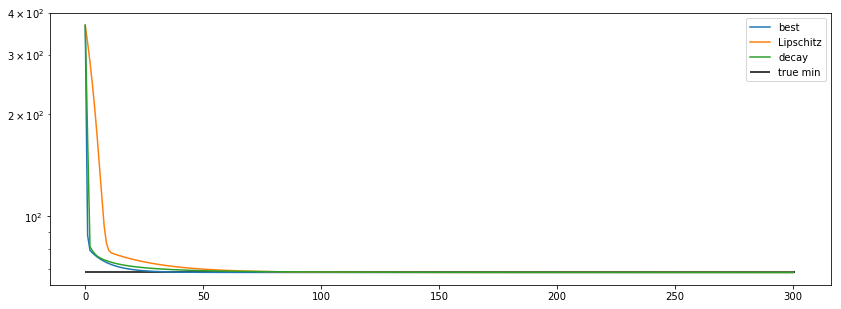

In [31]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(logreg.function_multi(best_results), label="best")
plt.plot(logreg.function_multi(lipschitz_results), label="Lipschitz")
plt.plot(logreg.function_multi(decay_results), label="decay")
plt.hlines([total_min], xmin=0, xmax=best_results.shape[0], label="true min")
plt.legend()
plt.show()

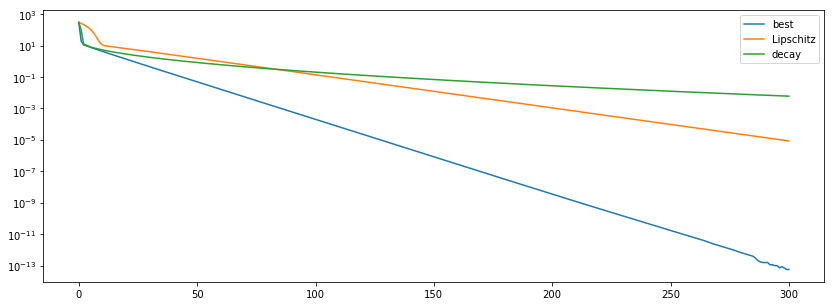

In [32]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(logreg.function_multi(best_results) - total_min, label="best")
plt.plot(logreg.function_multi(lipschitz_results) - total_min, label="Lipschitz")
plt.plot(logreg.function_multi(decay_results) - total_min, label="decay")
plt.legend()
plt.show()

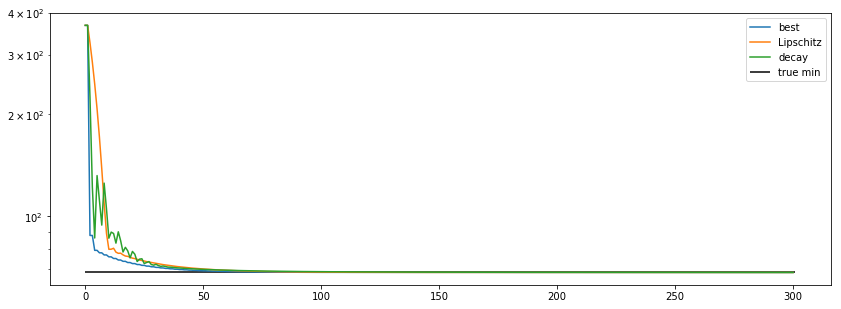

In [33]:

plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(logreg.function_multi(delayed_best_results), label="best")
plt.plot(logreg.function_multi(delayed_lipschitz_results), label="Lipschitz")
plt.plot(logreg.function_multi(delayed_decay_results), label="decay")
plt.hlines([total_min], xmin=0, xmax=best_results.shape[0], label="true min")
plt.legend()
plt.show()

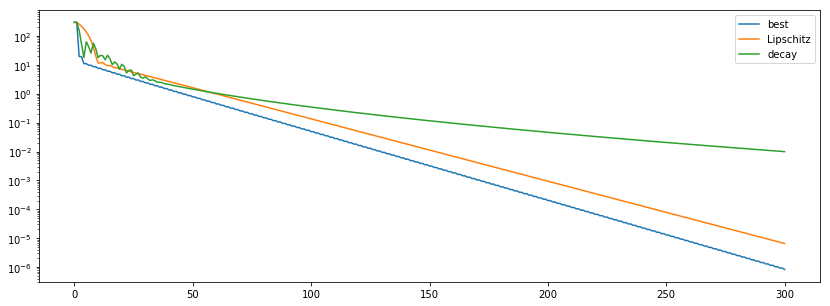

In [34]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(logreg.function_multi(delayed_best_results) - total_min, label="best")
plt.plot(logreg.function_multi(delayed_lipschitz_results) - total_min, label="Lipschitz")
plt.plot(logreg.function_multi(delayed_decay_results) - total_min, label="decay")
plt.legend()
plt.show()

In [35]:
ac_sa_results = AC_SA(np.ones(dims + 1) / (dims + 1), steps, logreg.gradient, logreg.lipschitz(), 1, logreg.prox_map)
print(ac_sa_results[-1])
delayed_ac_sa_results = AC_SA_delayed(np.ones(dims + 1) / (dims + 1), steps, logreg.gradient, logreg.lipschitz(), 1/10, logreg.prox_map)
print(delayed_ac_sa_results[-1])
double_delayed_ac_sa_results = AC_SA_double_delayed(np.ones(dims + 1) / (dims + 1), steps, logreg.gradient, logreg.lipschitz(), 1/10, logreg.prox_map)
print(double_delayed_ac_sa_results[-1])

[-0.03078872  0.04425836  0.01090661  0.01112973]
[-0.10422949  0.02749936 -0.02074924 -0.03496991]
[-0.12756663 -0.07576846 -0.75252129 -0.74622412]


In [36]:
newton_result = newton_descent(lipschitz_results[20], steps, logreg.gradient, logreg.hessian)
print(newton_result[-1])
delayed_newton_result = delayed_newton_descent(lipschitz_results[-1], steps, logreg.gradient, logreg.hessian)
print(delayed_newton_result[-1])

[-0.03568373  0.04434245  0.0110078   0.01115553]
[-0.0348408   0.04432798  0.01099038  0.01115108]


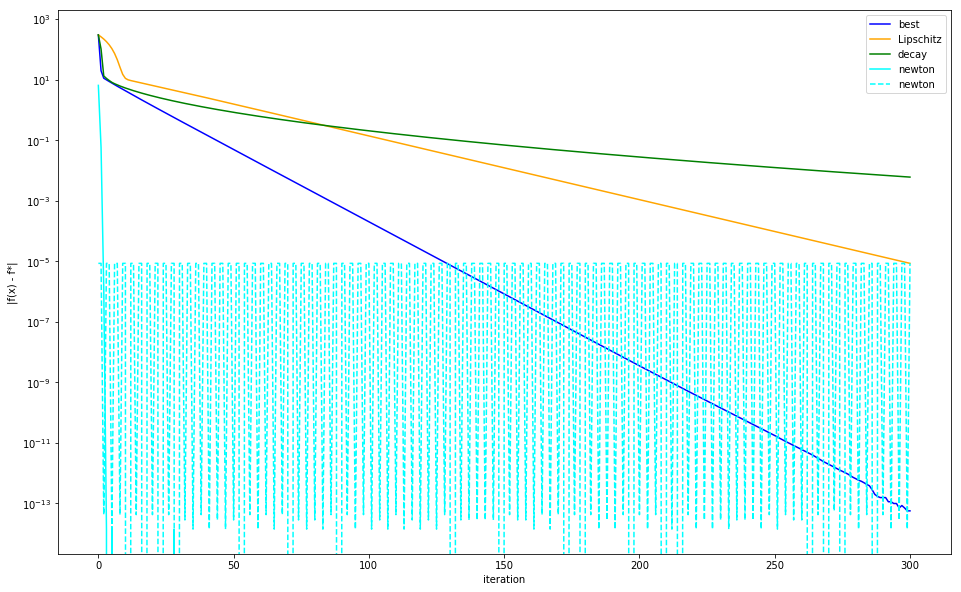

In [37]:
plt.figure(figsize=(16, 10))
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("|f(x) - f*|")

plt.plot(logreg.function_multi(best_results) - total_min, label="best", color='blue')
plt.plot(logreg.function_multi(lipschitz_results) - total_min, label="Lipschitz", color='orange')
plt.plot(logreg.function_multi(decay_results) - total_min, label="decay", color='green')
plt.plot(logreg.function_multi(newton_result) - total_min, label="newton", color='cyan')
plt.plot(logreg.function_multi(delayed_newton_result) - total_min, label="newton", color='cyan', linestyle="--")

plt.legend()
plt.show()

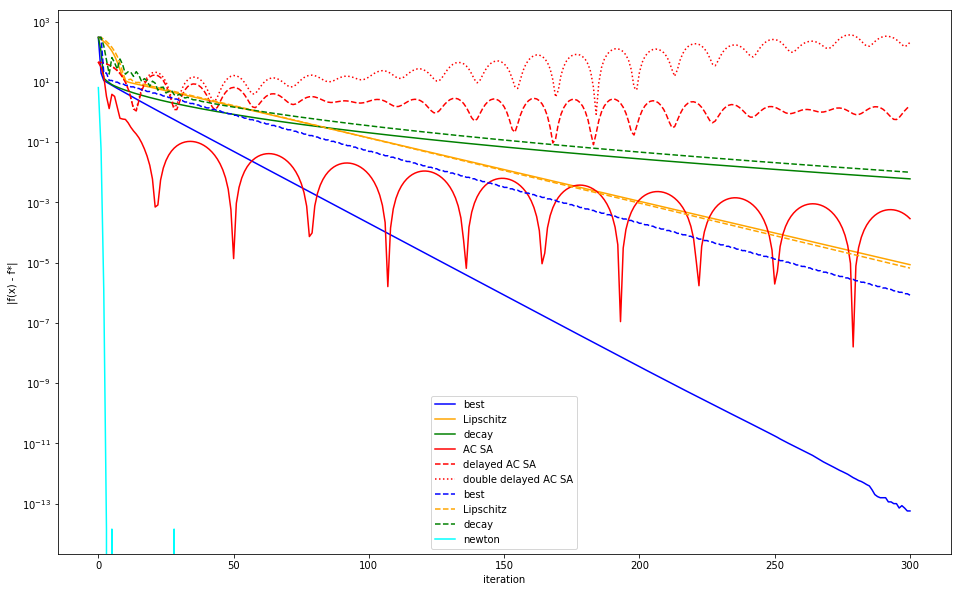

In [38]:
plt.figure(figsize=(16, 10))
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("|f(x) - f*|")

plt.plot(logreg.function_multi(best_results) - total_min, label="best", color='blue')
plt.plot(logreg.function_multi(lipschitz_results) - total_min, label="Lipschitz", color='orange')
plt.plot(logreg.function_multi(decay_results) - total_min, label="decay", color='green')

plt.plot(logreg.function_multi(ac_sa_results) - total_min, label="AC SA", color='red')
plt.plot(logreg.function_multi(delayed_ac_sa_results) - total_min, label="delayed AC SA", color='red',  linestyle="--")
plt.plot(logreg.function_multi(double_delayed_ac_sa_results) - total_min, label="double delayed AC SA", color='red',  linestyle=":")

plt.plot(logreg.function_multi(delayed_best_results) - total_min, label="best", color='blue', linestyle="--")
plt.plot(logreg.function_multi(delayed_lipschitz_results) - total_min, label="Lipschitz", color='orange', linestyle="--")
plt.plot(logreg.function_multi(delayed_decay_results) - total_min, label="decay", color='green', linestyle="--")

plt.plot(logreg.function_multi(newton_result) - total_min, label="newton", color='cyan')

plt.legend()
plt.show()